In [224]:
import os
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import json_normalize
warnings.filterwarnings("ignore")

In [225]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras import models
from tensorflow.keras import layers 
from PIL import Image 
from skimage.io import imread
import cv2
K.clear_session()

#### Trying to read an image as test

In [130]:
img = plt.imread('dataset/train/pizza/033.jpg')
dims = np.shape(img)
dims

(619, 1100, 3)

In [131]:
matrix = np.reshape(img , (dims[0] * dims[1] , dims[2]))
print(np.shape(matrix))

(680900, 3)


Image Shape:- (619, 1100)
Color Channels:- 3
Min Color Depth : 0, Max Color Depth 255


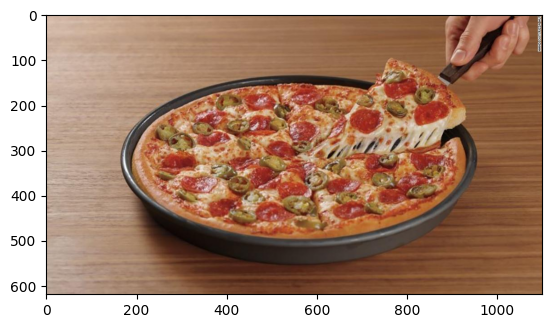

In [132]:
plt.imshow(img)
print("Image Shape:-" , dims[:2])
print("Color Channels:-", dims[2])
print("Min Color Depth : {}, Max Color Depth {}".format(np.min(img) , np.max(img)))

# Build the Model

Using Inception Model as it gives better results compared to Sequential Model (which gave 2% accuracy)

In [142]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image

# Resize all the images for InceptionV3 Model
IMAGE_SIZE = [299, 299]

# Import the ResNet152V2 Library as shown below.
inception_res = InceptionResNetV2(input_shape = IMAGE_SIZE + [3] , weights = "imagenet" , include_top = False)

# Don't train exiting weights
for layer in inception_res.layers:
    layer.trainable = False

In [143]:
from glob import glob
from tensorflow.keras.models import Model

# Get all the output classes
folders = glob("dataset/train/*")

In [144]:
from keras.layers import GlobalAveragePooling2D , Dropout

# Although this part can be done also with the functional API, I found that for this simple models, this becomes more intuitive
x =  inception_res.output
transfer_model=(GlobalAveragePooling2D())(x)
transfer_model=(Dense(824,activation='relu'))(transfer_model)
transfer_model=(Dropout(0.4))(transfer_model)
prediction=(Dense(len(folders), activation="softmax"))(transfer_model)

# create a model object
model = Model(inputs=inception_res.input, outputs=prediction)

In [145]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [146]:
# Compile the model
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [147]:
# Use Data Augmentation to Generate more images and helps to avoid overfitting
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


In [148]:
training_set = train_datagen.flow_from_directory('dataset/train',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')


Found 18466 images belonging to 91 classes.


In [149]:
val_set = val_datagen.flow_from_directory('dataset/val',
                                            target_size = (299, 299),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 8448 images belonging to 91 classes.


In [150]:
test_set = test_datagen.flow_from_directory('test',
                                            target_size = (299, 299),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 4212 images belonging to 91 classes.


In [152]:
# Train the model
history = model.fit_generator(
              training_set,
              validation_data=val_set,
              epochs=10,
              steps_per_epoch=len(training_set),
              validation_steps=len(val_set)
)

Epoch 1/10
578/578 [==============================] - 3871s 7s/step - loss: 2.7731 - accuracy: 0.3242 - val_loss: 1.9889 - val_accuracy: 0.4840
Epoch 2/10
578/578 [==============================] - 3595s 6s/step - loss: 2.0215 - accuracy: 0.4690 - val_loss: 1.7303 - val_accuracy: 0.5386
Epoch 3/10
578/578 [==============================] - 3365s 6s/step - loss: 1.8449 - accuracy: 0.5148 - val_loss: 1.6698 - val_accuracy: 0.5593
Epoch 4/10
578/578 [==============================] - 3472s 6s/step - loss: 1.7459 - accuracy: 0.5335 - val_loss: 1.6096 - val_accuracy: 0.5737
Epoch 5/10
578/578 [==============================] - 3428s 6s/step - loss: 1.6366 - accuracy: 0.5611 - val_loss: 1.5533 - val_accuracy: 0.5869
Epoch 6/10
578/578 [==============================] - 3298s 6s/step - loss: 1.5956 - accuracy: 0.5636 - val_loss: 1.5122 - val_accuracy: 0.5975
Epoch 7/10
578/578 [==============================] - 3421s 6s/step - loss: 1.5505 - accuracy: 0.5800 - val_loss: 1.5054 - val_accuracy:

In [153]:
# Save the model
from tensorflow.keras.models import load_model

model.save('model_resnet_2.h5')

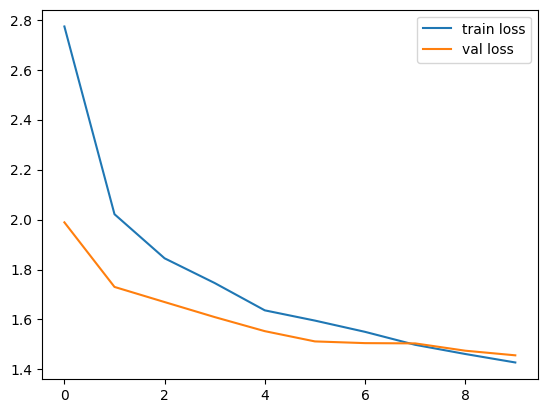

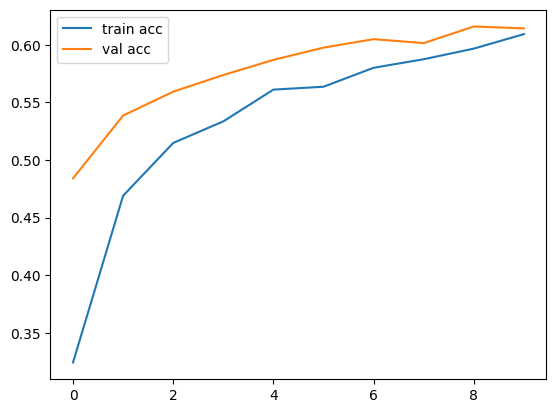

In [154]:
import matplotlib.pyplot as plt

# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

#### Load the Model

In [210]:
K.clear_session()
path_to_model='./model_resnet_2.h5'
print("Loading the model..")
model_inception = load_model(path_to_model)
print("Done!")

Loading the model..
Done!


#### Testing the Model

In [223]:
scores = model_inception.evaluate_generator(test_set)

print("Test Accuracy: {:.3f}".format(scores[1]))

Test Accuracy: 0.614


#### API Connection
I have chosen Edamam as they have a API and a free-tier that provides a list of recipes and their macros information. I will get the top 20 of the results and build a dataframe with all the info.

#### Connecting to the Edamam API

In [157]:
#Reading the secrets file

secrets_file = open("secrets.txt","r")
string = secrets_file.read()

secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        #print(line.split(':'))
        secrets_dict[line.split(':')[0]]=line.split(':')[1].strip()

#### Trying the Requests

In [158]:
import json
import requests

response = requests.get(f"https://api.edamam.com/api/recipes/v2?type=public&q=pasta&app_id={secrets_dict['clientid']}&app_key={secrets_dict['clientsecret']}")

results = response.json()
results

{'from': 1,
 'to': 20,
 'count': 10000,
 '_links': {'next': {'href': 'https://api.edamam.com/api/recipes/v2?q=pasta&app_key=baf55201008f28def6f1112b3497114e&_cont=CHcVQBtNNQphDmgVQntAEX4BYlxtBwABQG1CB2sRY1N2AAAVX3cSVmsSNgMhUlBUEmdCAGoWZAcgBgtSQGEUAGQRYFMhBhFqX3cWQT1OcV9xBE4%3D&type=public&app_id=b0424f5d',
   'title': 'Next page'}},
 'hits': [{'recipe': {'uri': 'http://www.edamam.com/ontologies/edamam.owl#recipe_09b4dbdf0c7244c462a4d2622d88958e',
    'label': 'Pasta Frittata Recipe',
    'image': 'https://edamam-product-images.s3.amazonaws.com/web-img/5a5/5a5220b7a65c911a1480502ed0532b5c.jpg?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEMr%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJHMEUCIGod%2FPwQl%2BSG1U7r2qICBeJMWbLUXQrteLIL5SZC6YzDAiEA%2BYZlpWJF8s0wn0n2cP3tAzEUBolP76BYpMU8JukfaM4quQUIQxAAGgwxODcwMTcxNTA5ODYiDJ%2BByIvT%2BlAutbCtzSqWBb9n4qtqxDNxtTwMUvkQnX6CrxuOnWAVF9nxY1X8vdeiiD%2BMpbi7ewEWVbdwENu3JhyLb4pxw06Fz9I5yRQS7oaWrPZdOxt7gcDVGBLjZmRolSqKwHJXgkm0os3E9f30gJgUfd3Lka1T6iyXDIH3dQLOky29

In [208]:
from PIL import Image
from io import BytesIO

In [160]:
train_labels = training_set.class_indices
train_labels = list(train_labels.keys())
train_labels

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'burger',
 'butter_naan',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'chai',
 'chapati',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'chole_bhature',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'dal_makhani',
 'deviled_eggs',
 'dhokla',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hot_and_sour_soup',
 'hot_dog',
 'huevo

In [351]:
labels = [s.replace("_", " ") for s in train_labels]
labels

['apple pie',
 'baby back ribs',
 'baklava',
 'beef carpaccio',
 'beef tartare',
 'beet salad',
 'beignets',
 'bibimbap',
 'bread pudding',
 'breakfast burrito',
 'bruschetta',
 'burger',
 'butter naan',
 'caesar salad',
 'cannoli',
 'caprese salad',
 'carrot cake',
 'ceviche',
 'chai',
 'chapati',
 'cheese plate',
 'cheesecake',
 'chicken curry',
 'chicken quesadilla',
 'chicken wings',
 'chocolate cake',
 'chocolate mousse',
 'chole bhature',
 'churros',
 'clam chowder',
 'club sandwich',
 'crab cakes',
 'creme brulee',
 'croque madame',
 'cup cakes',
 'dal makhani',
 'deviled eggs',
 'dhokla',
 'donuts',
 'dumplings',
 'edamame',
 'eggs benedict',
 'escargots',
 'falafel',
 'filet mignon',
 'fish and chips',
 'foie gras',
 'french fries',
 'french onion soup',
 'french toast',
 'fried calamari',
 'fried rice',
 'frozen yogurt',
 'garlic bread',
 'gnocchi',
 'greek salad',
 'grilled cheese sandwich',
 'grilled salmon',
 'guacamole',
 'gyoza',
 'hot and sour soup',
 'hot dog',
 'huevo

In [367]:
recipe_db = pd.DataFrame()
recipe_db.head()

""


In [368]:
import time

for label in labels:

    query = f"https://api.edamam.com/api/recipes/v2?type=public&q={label}&app_id={secrets_dict['clientid']}&app_key={secrets_dict['clientsecret']}"
    response = requests.get(query)
    results = response.json()
    
    if (results['count'] > 0):
        
        if 'hits' in results:
            index=0
            
            for index, value in enumerate(results['hits']):
                #print(index)

                ing = results['hits'][index]['recipe']['ingredientLines'] #pd.Series(results['hits'][i]['recipe']['ingredientLines'], dtype=object)
                
                # Convert ingredient list to a string
                ing_str = ',\n '.join(ing)

                #The nutrition info is a dictionary. Normalizing that might help.
                nut = json_normalize(results['hits'][index]['recipe']['totalNutrients']) #pd.Series(results['hits'][i]['recipe']['totalNutrients'], dtype=object)
                #print(nut)
                
                name = results['hits'][index]['recipe']['label']
                tn = results['hits'][index]['recipe']['images']['THUMBNAIL']['url']
                reg = results['hits'][index]['recipe']['images']['REGULAR']['url']
                src = results['hits'][index]['recipe']['source']
                src_url=results['hits'][index]['recipe']['url']
                instr = results['hits'][index]['recipe']['instructionLines']
                servings = results['hits'][index]['recipe']['yield']
                #print(label, name, ing_str ,tn ,reg, src, src_url)
                temp = pd.DataFrame({
                'category': [label],
                'dish_name': [name],
                'ingredient_lines': [ing_str],
                'img_tn': [tn],
                'img_reg': [reg],
                'source': [src],
                'source_url': [src_url], 
                'instructions': [instr],
                'servings':[servings]
                    })
                #Concatenating temp and calorie information into 1 dataframe
                temp = pd.concat([temp, nut], axis=1)

                #Concatenating everything into 1 big db
                recipe_db = pd.concat([recipe_db, temp], axis=0)
        elif 'message' in results:
            print("Limits exceeded")
            break;
    else:
        data = ({'category': ['kaathi roll'],
                    'dish_name': ['No recipe available']})
        temp = pd.DataFrame(data)
        recipe_db = pd.concat([recipe_db, temp], axis=0)
   
    time.sleep(10)

In [369]:
recipe_db = recipe_db.reset_index(drop=True)
recipe_db.head()

,category,dish_name,ingredient_lines,img_tn,img_reg,source,source_url,instructions,servings,ENERC_KCAL.label,ENERC_KCAL.quantity,ENERC_KCAL.unit,FAT.label,FAT.quantity,FAT.unit,FASAT.label,FASAT.quantity,FASAT.unit,FATRN.label,FATRN.quantity,FATRN.unit,FAMS.label,FAMS.quantity,FAMS.unit,FAPU.label,FAPU.quantity,FAPU.unit,CHOCDF.label,CHOCDF.quantity,CHOCDF.unit,CHOCDF.net.label,CHOCDF.net.quantity,CHOCDF.net.unit,FIBTG.label,FIBTG.quantity,FIBTG.unit,SUGAR.label,SUGAR.quantity,SUGAR.unit,SUGAR.added.label,SUGAR.added.quantity,SUGAR.added.unit,PROCNT.label,PROCNT.quantity,PROCNT.unit,CHOLE.label,CHOLE.quantity,CHOLE.unit,NA.label,NA.quantity,NA.unit,CA.label,CA.quantity,CA.unit,MG.label,MG.quantity,MG.unit,K.label,K.quantity,K.unit,FE.label,FE.quantity,FE.unit,ZN.label,ZN.quantity,ZN.unit,P.label,P.quantity,P.unit,VITA_RAE.label,VITA_RAE.quantity,VITA_RAE.unit,VITC.label,VITC.quantity,VITC.unit,THIA.label,THIA.quantity,THIA.unit,RIBF.label,RIBF.quantity,RIBF.unit,NIA.label,NIA.quantity,NIA.unit,VITB6A.label,VITB6A.quantity,VITB6A.unit,FOLDFE.label,FOLDFE.quantity,FOLDFE.unit,FOLFD.label,FOLFD.quantity,FOLFD.unit,FOLAC.label,FOLAC.quantity,FOLAC.unit,VITB12.label,VITB12.quantity,VITB12.unit,VITD.label,VITD.quantity,VITD.unit,TOCPHA.label,TOCPHA.quantity,TOCPHA.unit,VITK1.label,VITK1.quantity,VITK1.unit,WATER.label,WATER.quantity,WATER.unit
0,apple pie,Bourbon Apple Pie,"3 pounds Granny Smith apples, peeled, cored, d...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,Food52,https://food52.com/recipes/62862-bourbon-apple...,"[Preheat oven to 425F degrees., In a large bow...",6.0,Energy,2585.668557,kcal,Fat,84.396467,g,Saturated,36.540465,g,Trans,0.000000,g,Monounsaturated,30.040531,g,Polyunsaturated,8.406465,g,Carbs,437.191310,g,Carbohydrates (net),393.157001,g,Fiber,44.034309,g,Sugars,246.782223,g,"Sugars, added",115.725000,g,Protein,13.375914,g,Cholesterol,61.060000,mg,Sodium,1444.969320,mg,Calcium,180.139517,mg,Magnesium,97.597962,mg,Potassium,1916.554949,mg,Iron,5.299997,mg,Zinc,1.158231,mg,Phosphorus,283.053753,mg,Vitamin A,262.822856,µg,Vitamin C,6.215950,mg,Thiamin (B1),0.422129,mg,Riboflavin (B2),0.485822,mg,Niacin (B3),4.481521,mg,Vitamin B6,0.588093,mg,Folate equivalent (total),89.960000,µg,Folate (food),62.083313,µg,Folic acid,41.220000,µg,Vitamin B12,0.048280,µg,Vitamin D,0.000000,µg,Vitamin E,3.322379,mg,Vitamin K,46.585468,µg,Water,1299.504593,g
1,apple pie,Apple Pie Shake,"2 scoops vanilla ice cream,\n 1/2 cup whole mi...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,Food Network,https://www.foodnetwork.com/recipes/apple-pie-...,"[Place a tall glass in the freezer to chill., ...",1.0,Energy,195.058827,kcal,Fat,10.069222,g,Saturated,5.133150,g,NaN,NaN,NaN,Monounsaturated,3.029186,g,Polyunsaturated,1.036336,g,Carbs,20.944433,g,Carbohydrates (net),20.710102,g,Fiber,0.234331,g,Sugars,13.257887,g,"Sugars, added",7.096887,g,Protein,5.479656,g,Cholesterol,26.929388,mg,Sodium,120.121956,mg,Calcium,182.065380,mg,Magnesium,18.242874,mg,Potassium,242.963256,mg,Iron,0.283728,mg,Zinc,0.719196,mg,Phosphorus,143.054677,mg,Vitamin A,97.752791,µg,Vitamin C,0.530230,mg,Thiamin (B1),0.098520,mg,Riboflavin (B2),0.307253,mg,Niacin (B3),0.385725,mg,Vitamin B6,0.066188,mg,Folate equivalent (total),15.136294,µg,Folate (food),8.548794,µg,Folic acid,3.875000,µg,Vitamin B12,0.679556,µg,Vitamin D,1.652952,µg,Vitamin E,0.185828,mg,Vitamin K,0.466428,µg,Water,137.066663,g
2,apple pie,Apple Pie Bread,"½ cup butter, at room temperature,\n 1 cup sug...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,Honest Cooking,http://honestcooking.com/apple-pie-bread-recipe/,"[Preheat oven to 350 degrees F., Grease a 9×5-...",10.0,Energy,5271.524750,kcal,Fat,299.906445,g,Saturated,101.523473,g,Trans,0.712005,g,Monounsaturated,62.905101,g,Polyunsaturated,118.516461,g,Carbs,603.389527,g,Carbohydrates (net

In [370]:
recipe_db['category'].value_counts()

category
apple pie                  20
gnocchi                    20
huevos rancheros           20
hot dog                    20
hot and sour soup          20
gyoza                      20
guacamole                  20
grilled salmon             20
grilled cheese sandwich    20
greek salad                20
garlic bread               20
ice cream                  20
frozen yogurt              20
fried rice                 20
fried calamari             20
french toast               20
french onion soup          20
french fries               20
foie gras                  20
baby back ribs             20
hummus                     20
idli                       20
falafel                    20
nachos                     20
samosa                     20
pizza                      20
pav bhaji                  20
pancakes                   20
pad thai                   20
oysters                    20
onion rings                20
omelette                   20
mussels                    20
j

In [371]:
recipe_db.columns

Index(['category', 'dish_name', 'ingredient_lines', 'img_tn', 'img_reg',
       'source', 'source_url', 'instructions', 'servings', 'ENERC_KCAL.label',
       ...
       'VITD.unit', 'TOCPHA.label', 'TOCPHA.quantity', 'TOCPHA.unit',
       'VITK1.label', 'VITK1.quantity', 'VITK1.unit', 'WATER.label',
       'WATER.quantity', 'WATER.unit'],
      dtype='object', length=111)

In [372]:
recipe_db.shape
pd.set_option("display.max_columns", None)
recipe_db.head()

,category,dish_name,ingredient_lines,img_tn,img_reg,source,source_url,instructions,servings,ENERC_KCAL.label,ENERC_KCAL.quantity,ENERC_KCAL.unit,FAT.label,FAT.quantity,FAT.unit,FASAT.label,FASAT.quantity,FASAT.unit,FATRN.label,FATRN.quantity,FATRN.unit,FAMS.label,FAMS.quantity,FAMS.unit,FAPU.label,FAPU.quantity,FAPU.unit,CHOCDF.label,CHOCDF.quantity,CHOCDF.unit,CHOCDF.net.label,CHOCDF.net.quantity,CHOCDF.net.unit,FIBTG.label,FIBTG.quantity,FIBTG.unit,SUGAR.label,SUGAR.quantity,SUGAR.unit,SUGAR.added.label,SUGAR.added.quantity,SUGAR.added.unit,PROCNT.label,PROCNT.quantity,PROCNT.unit,CHOLE.label,CHOLE.quantity,CHOLE.unit,NA.label,NA.quantity,NA.unit,CA.label,CA.quantity,CA.unit,MG.label,MG.quantity,MG.unit,K.label,K.quantity,K.unit,FE.label,FE.quantity,FE.unit,ZN.label,ZN.quantity,ZN.unit,P.label,P.quantity,P.unit,VITA_RAE.label,VITA_RAE.quantity,VITA_RAE.unit,VITC.label,VITC.quantity,VITC.unit,THIA.label,THIA.quantity,THIA.unit,RIBF.label,RIBF.quantity,RIBF.unit,NIA.label,NIA.quantity,NIA.unit,VITB6A.label,VITB6A.quantity,VITB6A.unit,FOLDFE.label,FOLDFE.quantity,FOLDFE.unit,FOLFD.label,FOLFD.quantity,FOLFD.unit,FOLAC.label,FOLAC.quantity,FOLAC.unit,VITB12.label,VITB12.quantity,VITB12.unit,VITD.label,VITD.quantity,VITD.unit,TOCPHA.label,TOCPHA.quantity,TOCPHA.unit,VITK1.label,VITK1.quantity,VITK1.unit,WATER.label,WATER.quantity,WATER.unit
0,apple pie,Bourbon Apple Pie,"3 pounds Granny Smith apples, peeled, cored, d...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,Food52,https://food52.com/recipes/62862-bourbon-apple...,"[Preheat oven to 425F degrees., In a large bow...",6.0,Energy,2585.668557,kcal,Fat,84.396467,g,Saturated,36.540465,g,Trans,0.000000,g,Monounsaturated,30.040531,g,Polyunsaturated,8.406465,g,Carbs,437.191310,g,Carbohydrates (net),393.157001,g,Fiber,44.034309,g,Sugars,246.782223,g,"Sugars, added",115.725000,g,Protein,13.375914,g,Cholesterol,61.060000,mg,Sodium,1444.969320,mg,Calcium,180.139517,mg,Magnesium,97.597962,mg,Potassium,1916.554949,mg,Iron,5.299997,mg,Zinc,1.158231,mg,Phosphorus,283.053753,mg,Vitamin A,262.822856,µg,Vitamin C,6.215950,mg,Thiamin (B1),0.422129,mg,Riboflavin (B2),0.485822,mg,Niacin (B3),4.481521,mg,Vitamin B6,0.588093,mg,Folate equivalent (total),89.960000,µg,Folate (food),62.083313,µg,Folic acid,41.220000,µg,Vitamin B12,0.048280,µg,Vitamin D,0.000000,µg,Vitamin E,3.322379,mg,Vitamin K,46.585468,µg,Water,1299.504593,g
1,apple pie,Apple Pie Shake,"2 scoops vanilla ice cream,\n 1/2 cup whole mi...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,Food Network,https://www.foodnetwork.com/recipes/apple-pie-...,"[Place a tall glass in the freezer to chill., ...",1.0,Energy,195.058827,kcal,Fat,10.069222,g,Saturated,5.133150,g,NaN,NaN,NaN,Monounsaturated,3.029186,g,Polyunsaturated,1.036336,g,Carbs,20.944433,g,Carbohydrates (net),20.710102,g,Fiber,0.234331,g,Sugars,13.257887,g,"Sugars, added",7.096887,g,Protein,5.479656,g,Cholesterol,26.929388,mg,Sodium,120.121956,mg,Calcium,182.065380,mg,Magnesium,18.242874,mg,Potassium,242.963256,mg,Iron,0.283728,mg,Zinc,0.719196,mg,Phosphorus,143.054677,mg,Vitamin A,97.752791,µg,Vitamin C,0.530230,mg,Thiamin (B1),0.098520,mg,Riboflavin (B2),0.307253,mg,Niacin (B3),0.385725,mg,Vitamin B6,0.066188,mg,Folate equivalent (total),15.136294,µg,Folate (food),8.548794,µg,Folic acid,3.875000,µg,Vitamin B12,0.679556,µg,Vitamin D,1.652952,µg,Vitamin E,0.185828,mg,Vitamin K,0.466428,µg,Water,137.066663,g
2,apple pie,Apple Pie Bread,"½ cup butter, at room temperature,\n 1 cup sug...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,Honest Cooking,http://honestcooking.com/apple-pie-bread-recipe/,"[Preheat oven to 350 degrees F., Grease a 9×5-...",10.0,Energy,5271.524750,kcal,Fat,299.906445,g,Saturated,101.523473,g,Trans,0.712005,g,Monounsaturated,62.905101,g,Polyunsaturated,118.516461,g,Carbs,603.389527,g,Carbohydrates (net

##### Clean up the dataframe
- Remove unwanted colums (like label, unit)
- REname the remaining columns to meaningful names

In [373]:
drop_columns = [ 'ENERC_KCAL.label', 'ENERC_KCAL.unit','FAT.label', 'FAT.unit', 'FASAT.label', 'FASAT.unit', 'FATRN.label', 'FATRN.unit',
                'FAMS.label','FAMS.unit','FAPU.label', 'FAPU.unit','CHOCDF.label', 'CHOCDF.unit', 'CHOCDF.net.label', 'CHOCDF.net.unit', 
                'FIBTG.label', 'FIBTG.unit', 'SUGAR.label', 'SUGAR.unit', 'SUGAR.added.label','SUGAR.added.unit', 'PROCNT.label','PROCNT.unit',
                'CHOLE.label', 'CHOLE.unit',  'NA.label','NA.unit', 'CA.label','CA.unit','MG.label', 'MG.unit', 'K.label', 'K.unit', 
                'FE.label', 'FE.unit', 'ZN.label','ZN.unit','P.label', 'P.unit', 'VITA_RAE.label', 'VITA_RAE.unit','VITC.label', 'VITC.unit',
                'THIA.label', 'THIA.unit','RIBF.label', 'RIBF.unit', 'NIA.label','NIA.unit', 'VITB6A.label', 'VITB6A.unit','FOLDFE.label',
                'FOLDFE.quantity', 'FOLDFE.unit', 'FOLFD.label', 'FOLFD.quantity', 'FOLFD.unit','FOLAC.label','FOLAC.unit','VITB12.label',
                'VITB12.unit', 'VITD.label', 'VITD.unit','TOCPHA.label', 'TOCPHA.unit','VITK1.label','VITK1.unit','WATER.label', 'WATER.quantity',
                 'WATER.unit']


In [374]:
recipe_db = recipe_db.drop(drop_columns, axis=1)
recipe_db.head()

,category,dish_name,ingredient_lines,img_tn,img_reg,source,source_url,instructions,servings,ENERC_KCAL.quantity,FAT.quantity,FASAT.quantity,FATRN.quantity,FAMS.quantity,FAPU.quantity,CHOCDF.quantity,CHOCDF.net.quantity,FIBTG.quantity,SUGAR.quantity,SUGAR.added.quantity,PROCNT.quantity,CHOLE.quantity,NA.quantity,CA.quantity,MG.quantity,K.quantity,FE.quantity,ZN.quantity,P.quantity,VITA_RAE.quantity,VITC.quantity,THIA.quantity,RIBF.quantity,NIA.quantity,VITB6A.quantity,FOLAC.quantity,VITB12.quantity,VITD.quantity,TOCPHA.quantity,VITK1.quantity
0,apple pie,Bourbon Apple Pie,"3 pounds Granny Smith apples, peeled, cored, d...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,Food52,https://food52.com/recipes/62862-bourbon-apple...,"[Preheat oven to 425F degrees., In a large bow...",6.0,2585.668557,84.396467,36.540465,0.000000,30.040531,8.406465,437.191310,393.157001,44.034309,246.782223,115.725000,13.375914,61.060000,1444.969320,180.139517,97.597962,1916.554949,5.299997,1.158231,283.053753,262.822856,6.215950,0.422129,0.485822,4.481521,0.588093,41.220000,0.048280,0.000000,3.322379,46.585468
1,apple pie,Apple Pie Shake,"2 scoops vanilla ice cream,\n 1/2 cup whole mi...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,Food Network,https://www.foodnetwork.com/recipes/apple-pie-...,"[Place a tall glass in the freezer to chill., ...",1.0,195.058827,10.069222,5.133150,NaN,3.029186,1.036336,20.944433,20.710102,0.234331,13.257887,7.096887,5.479656,26.929388,120.121956,182.065380,18.242874,242.963256,0.283728,0.719196,143.054677,97.752791,0.530230,0.098520,0.307253,0.385725,0.066188,3.875000,0.679556,1.652952,0.185828,0.466428
2,apple pie,Apple Pie Bread,"½ cup butter, at room temperature,\n 1 cup sug...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,Honest Cooking,http://honestcooking.com/apple-pie-bread-recipe/,"[Preheat oven to 350 degrees F., Grease a 9×5-...",10.0,5271.524750,299.906445,101.523473,0.712005,62.905101,118.516461,603.389527,573.817815,29.571712,348.559184,265.425000,84.764095,686.797500,2351.109500,1289.404875,501.926250,2486.222625,25.370032,11.437245,2444.618000,1307.558500,14.622000,3.147834,2.584238,19.856102,1.820091,421.093750,1.303293,1.819125,7.268549,39.588937
3,apple pie,Apple Pie Crescents,"1 small Granny Smith apple, peeled, cored, cut...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,The Daily Meal,http://www.thedailymeal.com/apple-pie-crescent...,"[Heat oven to 375 degrees., Line cookie sheet ...",8.0,1376.510840,49.710113,24.753797,0.000000,14.250868,6.988104,210.661676,201.842153,8.819524,97.687602,71.133333,25.902404,100.661847,1086.681517,493.581876,75.931008,607.075030,9.516905,2.403512,309.134679,301.072962,0.851392,1.224665,0.901031,12.497034,0.311417,161.025291,0.367255,0.000000,1.915359,32.113196
4,apple pie,Apple-Pie Bread,"Baking spray with flour,\n ⅔ cup granulated su...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,EatingWell,http://www.eatingwell.com/recipe/280636/apple-...,"[Preheat oven to 350 degrees F., Coat a 9-by-5...",12.0,3017.898818,140.330831,62.400890,0.038000,32.547015,34.195515,396.335881,370.762524,25.573357,202.608034,159.438542,60.833303,604.862000,2665.961466,345.271167,282.112364,1326.826571,14.344477,6.742879,936.971779,852.726167,35.668333,1.835713,1.519564,13.693972,1.056696,204.531250,1.058980,2.000000,5.395313,19.068408


In [375]:
recipe_db = recipe_db.rename(columns = {'ENERC_KCAL.quantity': 'energy_kcal',
                'FAT.quantity': 'fat_g',
                'FASAT.quantity': 'fat_saturated_g',
                'FATRN.quantity': 'fat_trans_g',
                'FAMS.label': 'fat_monounsaturated_g',
                'FAPU.quantity': 'fat_poly_unsaturated_g',
                'CHOCDF.quantity': 'carbs_g',
                'CHOCDF.net.quantity':'carbs_net_g',
                'FIBTG.quantity': 'fibre_g',
                'SUGAR.quantity': 'sugar_g',
                'SUGAR.added.quantity': 'added_sugar_g',
                'PROCNT.quantity': 'protein_g',
                'CHOLE.quantity': 'cholestrol_mg',
                'NA.quantity': 'sodium_mg',
                'CA.quantity': 'calcium_mg',
                'MG.quantity': 'magnesium_mg',
                'K.quantity': 'potassium_mg',
                'FE.quantity': 'iron_mg',
                'ZN.quantity': 'zinc_mg',
                'P.quantity': 'phosphorus_mg',
                'VITA_RAE.quantity': 'vit_a_µg',
                'VITC.quantity': 'vit_c_mg',
                'THIA.quantity': 'thiamine_b1_mg',
                'RIBF.quantity': 'riboflavin_b2_mg',
                'NIA.quantity': 'niacin_b3_mg',
                'VITB6A.quantity': 'vit_b6_mg',
                'FOLAC.quantity': 'folic_acid_µg',
                'VITB12.quantity': 'vit_b12_µg',
                'VITD.quantity': 'vit_d_µg',
                'TOCPHA.quantity': 'vit_e_mg',
                'VITK1.quantity': 'vit_k_µg'
                })

In [380]:
recipe_db[recipe_db['category'] == 'kaathi roll']

,category,dish_name,ingredient_lines,img_tn,img_reg,source,source_url,instructions,servings,energy_kcal,fat_g,fat_saturated_g,fat_trans_g,FAMS.quantity,fat_poly_unsaturated_g,carbs_g,carbs_net_g,fibre_g,sugar_g,added_sugar_g,protein_g,cholestrol_mg,sodium_mg,calcium_mg,magnesium_mg,potassium_mg,iron_mg,zinc_mg,phosphorus_mg,vit_a_µg,vit_c_mg,thiamine_b1_mg,riboflavin_b2_mg,niacin_b3_mg,vit_b6_mg,folic_acid_µg,vit_b12_µg,vit_d_µg,vit_e_mg,vit_k_µg
1328,kaathi roll,No recipe available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [377]:

# Function to format links as Markdown hyperlinks
def format_link(link):
    return f'[Link]({link})'

# Apply the formatting function to the 'Links' column
#recipe_db['source_url'] = recipe_db['source_url'].apply(format_link)

#recipe_db.head()

In [378]:
#Formatting the data

#Check null values
recipe_db.isna().sum()

#Only fat_trans_g and added_sugar_g has NaN. Going to fill with 0

recipe_db['fat_trans_g'] = recipe_db['fat_trans_g'].fillna(0)
recipe_db['added_sugar_g'] = recipe_db['added_sugar_g'].fillna(0)

#the numerical columns have 4-5 decimal points. Removing decimal will be better

# Select only numeric columns
numeric_columns = recipe_db.select_dtypes(include='number')

# Round the numeric columns to the nearest whole number
recipe_db[numeric_columns.columns] = numeric_columns.round(0)

In [381]:
recipe_db.shape

(1743, 40)

In [382]:
#Save to csv

recipe_db.to_csv('recipe_database.csv', index=False)

#### Function to Predict an Image

In [204]:
def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(299, 299))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(labels[index]))
    plt.imshow(img_array)
    return labels[index]

1/1 [==============================] - 1s 669ms/step


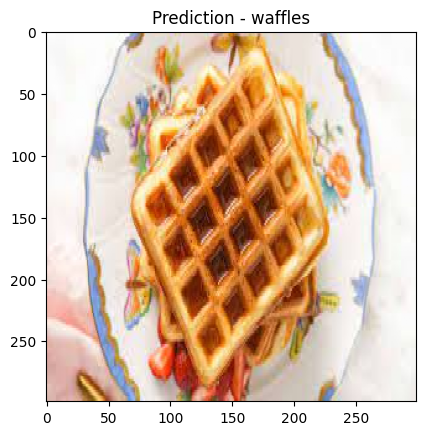

In [325]:
pred_ans = predict_image('Prediction/waffles.jpeg',model_inception)

In [214]:
pred_ans

'macaroni and cheese'

#### Based on the prediction, list 5 random recipes

In [237]:
recipe_db[recipe_db['category'] == pred_ans].sample(5)

,category,dish_name,ingredient_lines,img_tn,img_reg,source,source_url,energy_kcal,ENERC_KCAL.unit,fat_g,fat_saturated_g,fat_trans_g,FAMS.quantity,fat_poly_unsaturated_g,carbs_g,carbs_net_g,fibre_g,sugar_g,added_sugar_g,protein_g,cholestrol_mg,sodium_mg,calcium_mg,magnesium_mg,potassium_mg,iron_mg,zinc_mg,phosphorus_mg,vit_a_µg,vit_c_mg,thiamine_b1_mg,riboflavin_b2_mg,niacin_b3_mg,vit_b6_mg,folic_acid_µg,vit_b12_µg,vit_d_µg,vit_e_mg,vit_k_µg
1735,waffles,Chicken & Waffles Sliders,"1 lb. skinless, boneless chicken breast, cut i...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,Delish,http://www.delish.com/cooking/recipe-ideas/rec...,6626.363577,kcal,447.117426,63.813851,2.160755,242.076177,112.317585,445.537140,440.242140,5.295000,15.565640,NaN,205.502183,1182.942430,5318.200566,2766.185618,358.183864,3515.854516,25.471472,11.688688,3121.157748,923.179313,6.050000,3.045297,4.559324,63.923646,4.394886,279.00,4.172524,0.860000,63.895030,2.737000
1731,waffles,Chicken and Waffles,"Vegetable oil, for shallow frying,\n 1/4 cup h...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,Food Network,https://www.foodnetwork.com/recipes/food-netwo...,3265.145225,kcal,176.685098,48.721436,0.172320,67.296273,42.206914,305.483968,295.783087,9.700882,54.253180,50.21500,115.470233,670.562872,5300.593925,1061.610960,229.168978,2341.300662,16.437820,8.768976,1873.359626,588.051443,53.315761,1.975690,2.972073,38.723577,0.654633,93.00,2.852119,1.907185,6.577723,148.280244
1741,waffles,Waffle Sundae,"2 frozen whole grain waffles,\n 1/4 C nonfat p...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,Men's Health,https://www.menshealth.com/recipes/waffle-sund...,318.758125,kcal,11.118337,1.428417,0.001341,6.203042,2.652987,46.049750,41.397812,4.651937,15.727531,6.05000,10.071775,11.465000,485.239375,289.896875,60.633750,384.051875,4.328281,1.437125,410.669375,1.840000,8.607750,0.412322,0.803097,5.570672,0.714619,35.84,1.768825,0.000000,3.163525,7.705000
1732,waffles,Chocolate And Banana Waffle Panini,"2 frozen waffles,\n 1 tablespoon unsalted butt...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,Real Simple,http://www.realsimple.com/food-recipes/browse-...,725.878211,kcal,41.361962,16.587007,0.000000,11.447759,10.913507,80.663665,77.486943,3.176722,22.516710,15.45049,13.791945,134.030000,771.758948,397.872347,77.005452,552.486759,4.505590,1.578817,338.556371,196.363500,5.632950,0.428736,0.593073,3.616719,0.306658,46.50,0.399140,0.000000,0.460999,2.870823
1739,waffles,Glazed Waffle Donuts,6 Kellogg's® Eggo® Thick & Fluffy Original waf...,https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,Food Network,https://www.foodnetwork.com/recipes/glazed-waf...,1748.658500,kcal,64.668750,13.612500,NaN,16.144500,30.583125,256.700000,256.700000,0.000000,106.729650,104.83590,36.731250,314.250000,2317.695500,1190.945500,89.250000,767.141000,10.469775,3.209455,886.500000,309.750000,1.800000,1.200750,1.645214,9.348375,0.265500,139.50,1.293750,0.487500,0.026250,0.112500


In [253]:
pd.set_option("display.max_rows", None)

recipe_db['category'].value_counts()

category
apple pie                  20
gnocchi                    20
huevos rancheros           20
hot dog                    20
hot and sour soup          20
gyoza                      20
guacamole                  20
grilled salmon             20
grilled cheese sandwich    20
greek salad                20
garlic bread               20
ice cream                  20
frozen yogurt              20
fried rice                 20
fried calamari             20
french toast               20
french onion soup          20
french fries               20
foie gras                  20
baby back ribs             20
hummus                     20
idli                       20
falafel                    20
nachos                     20
samosa                     20
pizza                      20
pav bhaji                  20
pancakes                   20
pad thai                   20
oysters                    20
onion rings                20
omelette                   20
mussels                    20
j

In [229]:
la = list(recipe_db['category'].unique())

In [256]:
len(recipe_db[recipe_db['category'] == pred_ans])

20

In [303]:
subset = recipe_db[recipe_db['category'] == pred_ans].sample(5)

In [304]:
subset.head()

,category,dish_name,ingredient_lines,img_tn,img_reg,source,source_url,instructions,energy_kcal,fat_g,fat_saturated_g,fat_trans_g,FAMS.quantity,fat_poly_unsaturated_g,carbs_g,carbs_net_g,fibre_g,sugar_g,added_sugar_g,protein_g,cholestrol_mg,sodium_mg,calcium_mg,magnesium_mg,potassium_mg,iron_mg,zinc_mg,phosphorus_mg,vit_a_µg,vit_c_mg,thiamine_b1_mg,riboflavin_b2_mg,niacin_b3_mg,vit_b6_mg,folic_acid_µg,vit_b12_µg,vit_d_µg,vit_e_mg,vit_k_µg
1734,waffles,Waffles and Honey Berry Ricotta,"2 frozen whole grain waffles,\n 2/3 cup fat-fr...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,Men's Health,https://www.menshealth.com/recipes/waffles-and...,[Toast 2 frozen whole grain waffles and spread...,544.550000,23.694800,11.667040,0.550560,7.795427,2.385413,68.355233,63.253108,5.102125,24.211113,5.798313,17.876921,91.253333,620.109167,475.970417,58.087917,574.432500,4.377396,1.416604,535.055833,202.840000,14.391313,0.424413,0.975257,5.832892,0.891828,35.84,2.800533,0.330667,1.633467,35.566667
1732,waffles,Chocolate And Banana Waffle Panini,"2 frozen waffles,\n 1 tablespoon unsalted butt...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,Real Simple,http://www.realsimple.com/food-recipes/browse-...,[],725.878211,41.361962,16.587007,0.000000,11.447759,10.913507,80.663665,77.486943,3.176722,22.516710,15.450490,13.791945,134.030000,771.758948,397.872347,77.005452,552.486759,4.505590,1.578817,338.556371,196.363500,5.632950,0.428736,0.593073,3.616719,0.306658,46.50,0.399140,0.000000,0.460999,2.870823
1738,waffles,Banana-Nut Waffle Sundae,"1 banana,\n 2 whole-grain frozen waffles,\n 1/...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,Men's Health,https://www.menshealth.com/recipes/banana-nut-...,"[Slice half a banana., Toast 2 whole-grain fro...",678.780500,31.355910,5.417676,0.004440,6.662256,17.166341,80.397225,76.409150,3.988075,16.894712,NaN,22.882130,107.200000,794.589500,484.017500,90.986500,821.542250,4.243207,2.030262,460.956500,101.857250,10.856025,0.497258,0.832618,4.192125,0.633775,46.50,0.930000,0.000000,0.225475,0.973375
1731,waffles,Chicken and Waffles,"Vegetable oil, for shallow frying,\n 1/4 cup h...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,Food Network,https://www.foodnetwork.com/recipes/food-netwo...,[Heat about 1 inch of oil in a large cast-iron...,3265.145225,176.685098,48.721436,0.172320,67.296273,42.206914,305.483968,295.783087,9.700882,54.253180,50.215000,115.470233,670.562872,5300.593925,1061.610960,229.168978,2341.300662,16.437820,8.768976,1873.359626,588.051443,53.315761,1.975690,2.972073,38.723577,0.654633,93.00,2.852119,1.907185,6.577723,148.280244
1727,waffles,Carrot Cake Waffle Breakfast Sandwich,"2 whole-grain frozen waffles,\n 2 tablespoons ...",https://edamam-product-images.s3.amazonaws.com...,https://edamam-product-images.s3.amazonaws.com...,EatingWell,http://www.eatingwell.com/recipe/250658/carrot...,"[Toast waffles., Spread cream cheese on 1 waff...",699.152500,36.093337,10.648732,0.339481,8.530020,14.124757,80.963288,77.949725,3.013562,23.930781,7.940625,15.915675,132.790000,906.083750,462.551250,59.265000,666.903125,4.231569,1.795544,380.706250,696.243125,4.710937,0.494241,0.822893,3.962389,0.255488,46.50,0.438800,0.000000,0.724937,9.492812


In [307]:
recipes_reset = subset.reset_index(drop=True)
recipes_reset.index += 1
recipes_reset = recipes_reset[['dish_name', 'img_reg', 'energy_kcal', 'source', 'source_url']]

"""Converts a column into clickable hyperlinks in a table."""
# Extract the column values
sources = recipes_reset['source'].tolist()
links = recipes_reset['source_url'].tolist()

# Create HTML links
hyperlinks = []
for source, link in zip(sources, links):
    href = f"<a href='{link}'>{source}</a>"
    hyperlinks.append(href)

# Replace original column values with hyperlinks
recipes_reset.loc[:, 'source_link'] = hyperlinks

In [308]:
recipes_reset.head()

,dish_name,img_reg,energy_kcal,source,source_url,source_link
1,Waffles and Honey Berry Ricotta,https://edamam-product-images.s3.amazonaws.com...,544.550000,Men's Health,https://www.menshealth.com/recipes/waffles-and...,<a href='https://www.menshealth.com/recipes/wa...
2,Chocolate And Banana Waffle Panini,https://edamam-product-images.s3.amazonaws.com...,725.878211,Real Simple,http://www.realsimple.com/food-recipes/browse-...,<a href='http://www.realsimple.com/food-recipe...
3,Banana-Nut Waffle Sundae,https://edamam-product-images.s3.amazonaws.com...,678.780500,Men's Health,https://www.menshealth.com/recipes/banana-nut-...,<a href='https://www.menshealth.com/recipes/ba...
4,Chicken and Waffles,https://edamam-product-images.s3.amazonaws.com...,3265.145225,Food Network,https://www.foodnetwork.com/recipes/food-netwo...,<a href='https://www.foodnetwork.com/recipes/f...
5,Carrot Cake Waffle Breakfast Sandwich,https://edamam-product-images.s3.amazonaws.com...,699.152500,EatingWell,http://www.eatingwell.com/recipe/250658/carrot...,<a href='http://www.eatingwell.com/recipe/2506...


In [309]:
recipes_reset['source_url'] = recipes_reset['source_url'].apply(format_link)

In [323]:
len(labels)

91